In [7]:
import os
#Set current location to the location of the script
os.chdir(os.path.dirname("/dust3r/masked_dust3r/playground.ipynb"))
os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd())

/dust3r


In [8]:
#Display imgs
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import open3d as o3d

In [9]:
from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [10]:
device = 'cuda'
batch_size = 1
schedule = 'cosine'
lr = 0.01
niter = 300

model_name = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
# you can put the path to a local checkpoint in model_name if needed
model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)
# load_images can take a list of images or a directory
images = load_images(['croco/assets/Chateau1.png', 'croco/assets/Chateau2.png'], size=512, verbose=True)

... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 2 images
 - adding croco/assets/Chateau1.png with resolution 224x224 --> 512x384
 - adding croco/assets/Chateau2.png with resolution 224x224 --> 512x384
 (Found 2 images)


In [11]:
pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
output = inference(pairs, model, device, batch_size=batch_size)

>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


In [12]:
view1, pred1 = output['view1'], output['pred1']
view2, pred2 = output['view2'], output['pred2']

In [13]:
scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

 init edge (1*,0*) score=48.34415817260742
 init loss = 0.006030057556927204
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 300/300 [00:17<00:00, 16.82it/s, lr=1.27413e-06 loss=0.00275613]


In [14]:
imgs = scene.imgs
focals = scene.get_focals()
poses = scene.get_im_poses()
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks()

(-0.5, 511.5, 383.5, -0.5)

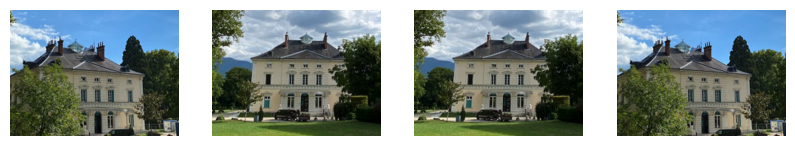

In [15]:
#Rescale images
img1 = view1["img"][0].numpy()
img2 = view1["img"][1].numpy()
img3 = view2["img"][0].numpy()
img4 = view2["img"][1].numpy()

img1 = img1 + 1
img1 = img1 / 2
img1 = np.uint8(img1*255).transpose(1, 2, 0)
img2 = img2 + 1
img2 = img2 / 2
img2 = np.uint8(img2*255).transpose(1, 2, 0)
img3 = img3 + 1
img3 = img3 / 2
img3 = np.uint8(img3*255).transpose(1, 2, 0)
img4 = img4 + 1
img4 = img4 / 2
img4 = np.uint8(img4*255).transpose(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(img1)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img2)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img3)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img4)
plt.axis('off')

(-0.5, 511.5, 383.5, -0.5)

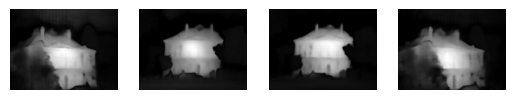

In [16]:
conf1 = pred1["conf"][0].numpy()
conf2 = pred1["conf"][1].numpy()
conf3 = pred2["conf"][0].numpy()
conf4 = pred2["conf"][1].numpy()

plt.subplot(1, 4, 1)
plt.imshow(conf1, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(conf2, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(conf3, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(conf4, cmap='gray')
plt.axis('off')

In [17]:
pointcloud1 = pts3d[0].detach().cpu().numpy()
pointcloud1 = pointcloud1.reshape(-1, 3)
color1 = imgs[0].reshape(-1, 3)

pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(pointcloud1)
pcd1.colors = o3d.utility.Vector3dVector(color1)
o3d.io.write_point_cloud("pointcloud1.ply", pcd1)

pointcloud2 = pts3d[1].detach().cpu().numpy()
pointcloud2 = pointcloud2.reshape(-1, 3)
color2 = imgs[1].reshape(-1, 3)

pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(pointcloud2)
pcd2.colors = o3d.utility.Vector3dVector(color2)
o3d.io.write_point_cloud("pointcloud2.ply", pcd2)

True

In [18]:
print(pointcloud1.shape)

(196608, 3)
